# Big Data Report On Uk 2020 Accident Record

In [ ]:
import Exce
name = ""
try:
    print(int(name))
except Exception as ex:
    print(ex)

In [1]:
# Libraries Importation
import sqlite3
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

In [2]:


# Suppress all warnings
warnings.filterwarnings("ignore")

# warnings.filterwarnings("default") i will return to default once done

# Report Questions Begins

#### Helper Functions

In [3]:
weekday_list = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

In [4]:
# with connection as cursor:

In [5]:
# this is an helper function that i wrote to receive sql command
# query the database and return the pandas result dataframe
def read_sql_to_pandas(query):
    # Assuming db_connection is a valid SQLite connection
    try:
        with sqlite3.connect("accident_data_v1.0.0_2023.db") as db_connection: #connection established
            cur = db_connection.cursor() #create a cursor for execution
            cur.execute(query) #execute query
            table_query_result = cur.fetchall() #fetch all record from the query
            cols = [description[0] for description in cur.description] #filter out the columns from the query
            pandas_result = pd.DataFrame(table_query_result, columns=cols) # convert the result to pandas
            return pandas_result #return pandas 
    except Exception as ex:
        print(ex)
    

##### This function below helps gerenate timeStamp and Day of the week. I wrote it to avoid repitition of same code later. I and going to use it multiple times

In [6]:
# This function below helps gerenate timeStamp and Day of the week. 
# I wrote it to avoid repitition of same code later. I and going to use it multiple times
def helper(dataF):
    dataF['Timestamp'] = pd.to_datetime(dataF['date']\
    + ' ' + dataF['time'], format='%d/%m/%Y %H:%M')
    
    # Map numerical day of the week to weekday names
    dataF['DayOfWeek'] = dataF['day_of_week']\
    .map(lambda x: weekday_list[x-1])
    
    # Extract Time Information
    dataF['Hour'] = dataF['Timestamp'].dt.hour
    return dataF

# This function below helps gerenate timeStamp and Day of the week
# I wrote it to avoid repitition of same code later
# I amd going to use it multiple times

### 1. Are there significant hours of the day, and days of the week, on which accidents occur?

In [7]:
# reading from sql using the helper function I created above
accident_dataF = read_sql_to_pandas("""                       
        select * from accident where accident_year = 2020
        """)
accident_dataF.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,9,1,9,9,0,0,1,3,2,E01004576
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,4,1,1,1,0,0,1,1,2,E01003034
2,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,0,4,1,2,0,0,1,1,2,E01004726
3,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,4,4,1,1,0,0,1,1,2,E01003617
4,2020010228011,2020,010228011,529324.0,181286.0,-0.137592,51.515704,1,3,1,...,0,4,1,1,0,0,1,1,2,E01004763


In [8]:
# call function to Generate convert days of the week 
# from number format to Sunday -> Saturday add timestamp and hour as well
convert_sig_hourDf = helper(accident_dataF)

#### Accident by Significant Days of the week

In [9]:
# Calculate Accident Counts by Days of the Week
accident_count_daily = convert_sig_hourDf['DayOfWeek'].value_counts().reindex(weekday_list)
# print out 
accident_count_daily.sort_values(ascending=False)

DayOfWeek
Friday       14889
Thursday     14056
Wednesday    13564
Tuesday      13267
Monday       12772
Saturday     12336
Sunday       10315
Name: count, dtype: int64

#### Accident by days of the week and hours, with 10 highest count of accident recorded

In [10]:
# some ideas from https://stackoverflow.com/questions/39778686/pandas-reset-index-after-groupby-value-counts
# group accident by day of the week and hour(DOW)
grouped_dow_count = convert_sig_hourDf.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')
# print out top ten with higest accident count
grouped_dow_count.nlargest(10, 'Count')

,DayOfWeek,Hour,Count
113,Thursday,17,1288
17,Friday,17,1273
15,Friday,15,1229
41,Monday,17,1214
137,Tuesday,17,1213
112,Thursday,16,1209
161,Wednesday,17,1197
16,Friday,16,1181
111,Thursday,15,1178
160,Wednesday,16,1160


##### Plot of accident by Days of the Week

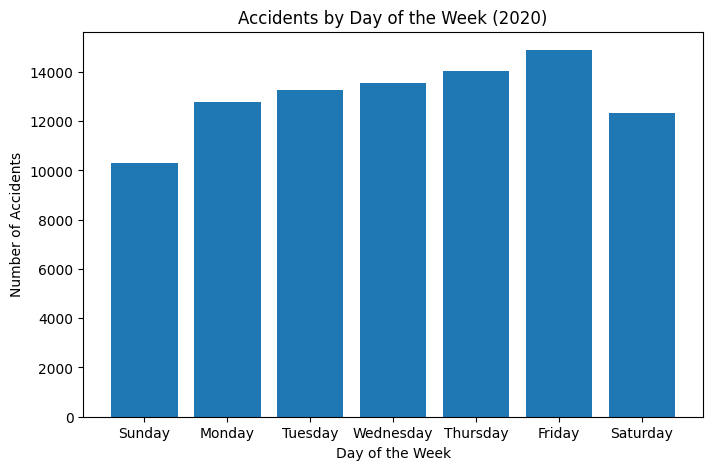

In [11]:
# some ideas from  https://www.freecodecamp.org/news/matplotlib-figure-size-change-plot-size-in-python/
plt.figure(figsize=(8, 5))
plt.bar(weekday_list, accident_count_daily.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Day of the Week (2020)')
plt.show()

##### Significant hours of the day

In [12]:
# Calculate Accident Counts by hours of the day
hourly_accident_counts = convert_sig_hourDf['Hour'].value_counts().sort_index()

In [13]:
# show 5 hours with highest number of accident
hourly_accident_counts.nlargest(10)

Hour
17    7813
16    7381
15    7361
18    6618
14    6245
13    5741
12    5395
8     5267
19    5048
11    4812
Name: count, dtype: int64

#### Plot of accident by Hours of the day

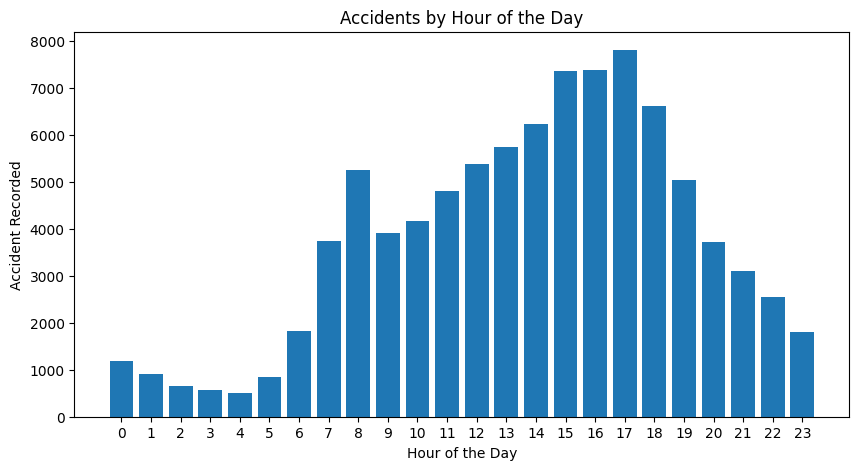

In [14]:
#  Visualize the Data
# inspired by https://stackabuse.com/change-figure-size-in-matplotlib/
plt.figure(figsize=(10, 5))
plt.bar(hourly_accident_counts.index, hourly_accident_counts.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Accident Recorded')
plt.title('Accidents by Hour of the Day')

plt.xticks(range(24))
plt.show()


#### 
#### 
### 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

In [15]:
# read motorcycle_125cc, motorcycle_125cc_500cc and motorcycle_over_500cc
motorbikes_df_=read_sql_to_pandas("""
    select * from accident as ac
    join vehicle on ac.accident_index = vehicle.accident_index
    where (vehicle_type =3 or vehicle_type = 4
    or vehicle_type = 5) and ac.accident_year = 2020
""")

In [16]:
# call helper function to help 
# add day of the week  and time to the data and return dataframe
motorbikes_df = helper(motorbikes_df_)

#### Separate motor bikes into their respective types

In [17]:
# get motocycle with 125cc and under into dataframe
motorbike_125cc = motorbikes_df[motorbikes_df["vehicle_type"] == 3]
# total accident by this category
len(motorbike_125cc)

7523

In [18]:
# get motocycle with over 125cc and up to 500cc into dataframe
motorbike_125cc_500cc = motorbikes_df[motorbikes_df["vehicle_type"] == 4]
# total accident by this category
len(motorbike_125cc_500cc)

1691

In [19]:
# get motocycle with over 500cc into dataframe
motorbike_over_500cc =motorbikes_df[motorbikes_df["vehicle_type"] == 5]
# total accident by this category
len(motorbike_over_500cc)

3784

#### Accident By Hours of the day

##### Count of accident recorded by filtered motorbikes

In [20]:
# count of accident from motobike 125cc and below
motorbike_125cc_counts = motorbike_125cc['Hour'].value_counts().sort_index()

# count of accident over 125cc and up to 500cc
motorbike_125cc_500cc_counts = motorbike_125cc_500cc['Hour'].value_counts().sort_index()

# count of accident over 500cc
motorbike_over_500cc_counts = motorbike_over_500cc['Hour'].value_counts().sort_index()

In [21]:
# get 5 highest count of accidents and the Hour they happend
motorbike_125cc_counts.nlargest(5)

Hour
18    705
17    692
16    603
19    580
15    551
Name: count, dtype: int64

In [22]:
# get 5 highest count of accidents and the Hour they happend
motorbike_125cc_500cc_counts.nlargest(5)

Hour
17    175
16    157
15    151
14    131
18    128
Name: count, dtype: int64

In [23]:
# get 5 highest count of accidents and the Hour they happend
motorbike_over_500cc_counts.nlargest(5)

Hour
17    421
16    366
15    336
13    323
14    323
Name: count, dtype: int64

#### Plot of the accident frequencies by hour for each motorbike categories e.g Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc

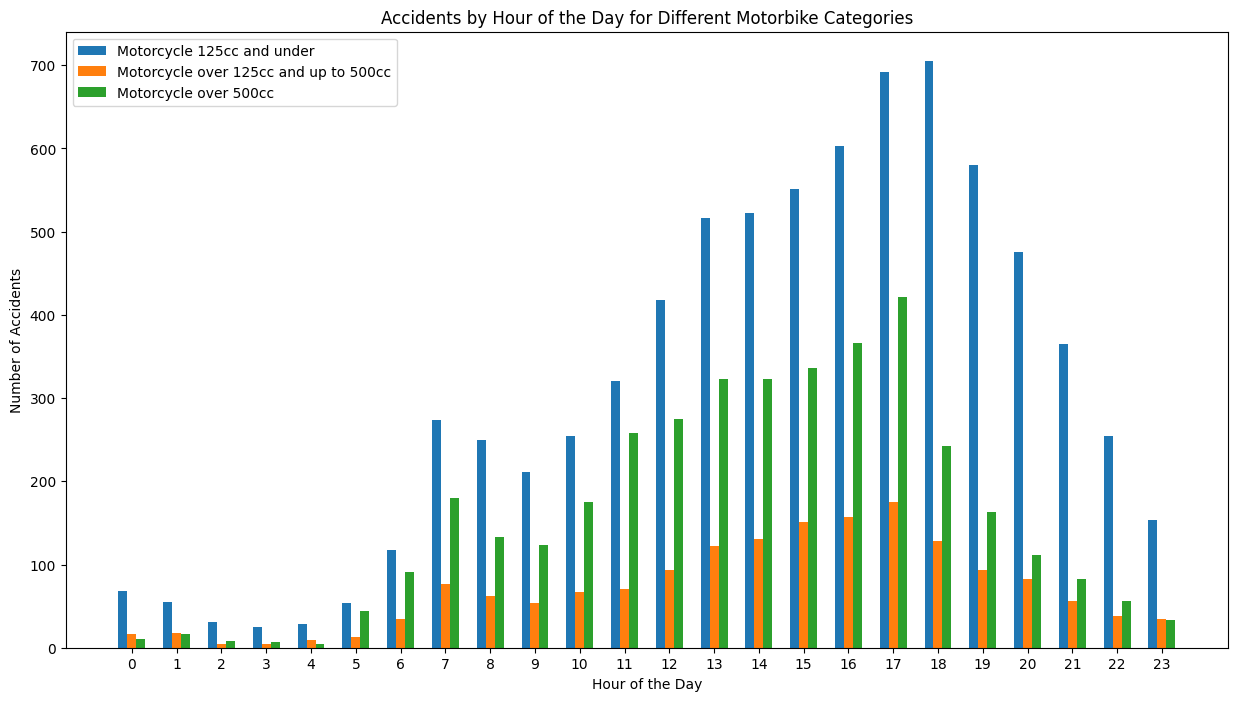

In [24]:
#got the idea from https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
# bar plot to visualize the accident frequencies by hour for each motorbike category
plt.figure(figsize=(15, 8))
width = 0.2

plt.bar(motorbike_125cc_counts.index - width, motorbike_125cc_counts.values, width=width, label='Motorcycle 125cc and under')
plt.bar(motorbike_125cc_500cc_counts.index, motorbike_125cc_500cc_counts.values, width=width, label='Motorcycle over 125cc and up to 500cc')
plt.bar(motorbike_over_500cc_counts.index + width, motorbike_over_500cc_counts.values, width=width, label='Motorcycle over 500cc')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Hour of the Day for Different Motorbike Categories')
plt.xticks(range(0, 24))
plt.legend()
plt.show()



#### Significant Days of the Week

In [25]:
# count of accident from motobike 125cc and below
motorbike_125cc_counts_ = motorbike_125cc['DayOfWeek'].value_counts().sort_index()

# count of accident over 125cc and up to 500cc
motorbike_125cc_500cc_counts_ = motorbike_125cc_500cc['DayOfWeek'].value_counts().sort_index()

# count of accident over 500cc
motorbike_over_500cc_counts_ = motorbike_over_500cc['DayOfWeek'].value_counts().sort_index()

##### Display of Count by day of the week for Motor bike 125 and below

In [26]:
motorbike_125cc_counts_

DayOfWeek
Friday       1285
Monday       1008
Saturday     1043
Sunday        845
Thursday     1219
Tuesday      1034
Wednesday    1089
Name: count, dtype: int64

##### Display of Count by day of the week for Motor bike 125cc and up to 500cc

In [27]:
motorbike_125cc_500cc_counts_.nlargest(7)

DayOfWeek
Friday       267
Thursday     257
Wednesday    251
Saturday     237
Tuesday      234
Monday       227
Sunday       218
Name: count, dtype: int64

##### Display of Count by day of the week for Motor bike over 500cc

In [28]:
motorbike_over_500cc_counts_.nlargest(7)

DayOfWeek
Sunday       675
Friday       567
Saturday     550
Thursday     526
Wednesday    501
Tuesday      497
Monday       468
Name: count, dtype: int64

##### Display of day, hour and count of accident for Motor bike 125 and below

In [29]:
motor_bike_125cc = motorbike_125cc.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')
motor_bike_125cc.nlargest(10, columns = "Count")

,DayOfWeek,Hour,Count
113,Thursday,17,127
114,Thursday,18,127
17,Friday,17,119
16,Friday,16,115
112,Thursday,16,107
18,Friday,18,106
161,Wednesday,17,103
19,Friday,19,101
41,Monday,17,101
66,Saturday,18,101


##### Display of day, hour and count of accident for Motor bike 125cc and up to 500cc

In [30]:
# Display of day, hour and count of accident for Motor bike 125cc and up to 500cc
motor_bike_125cc = motorbike_125cc_500cc.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')
motor_bike_125cc.nlargest(10, columns = "Count")

,DayOfWeek,Hour,Count
124,Tuesday,16,34
105,Thursday,17,33
79,Sunday,15,31
35,Monday,16,29
106,Thursday,18,28
15,Friday,17,27
36,Monday,17,25
77,Sunday,13,25
12,Friday,14,24
125,Tuesday,17,24


##### Display of day, hour and count of accident for Motor bike over 500cc

In [31]:
motor_bike_over_500cc = motorbike_over_500cc.groupby(['DayOfWeek', 'Hour']).size().reset_index(name='Count')
motor_bike_over_500cc.nlargest(20, columns = "Count")

,DayOfWeek,Hour,Count
80,Sunday,13,80
81,Sunday,14,74
78,Sunday,11,73
79,Sunday,12,71
128,Tuesday,17,70
39,Monday,17,67
56,Saturday,13,67
82,Sunday,15,67
150,Wednesday,17,66
83,Sunday,16,63


#### Plot of count of accident by days of the week

In [32]:
# assign sorted bike categories by week to variables
sorted_125 = motorbike_125cc['DayOfWeek'].value_counts()[weekday_list]
sorted_125_500 = motorbike_125cc_500cc['DayOfWeek'].value_counts()[weekday_list]
sorted_500_over = motorbike_over_500cc['DayOfWeek'].value_counts()[weekday_list]

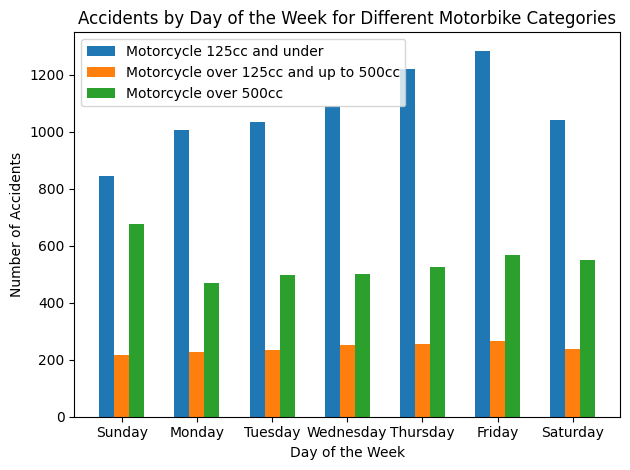

In [33]:
#got the idea from https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/

plt.bar([day - width for day in range(1, 8)], sorted_125, width=width, label='Motorcycle 125cc and under')
plt.bar(range(1, 8), sorted_125_500, width=width, label='Motorcycle over 125cc and up to 500cc')
plt.bar([day + width for day in range(1, 8)], sorted_500_over, width=width, label='Motorcycle over 500cc')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Day of the Week for Different Motorbike Categories')
plt.xticks(range(1, 8), weekday_list)
plt.legend()
plt.tight_layout()
plt.show()







### 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [34]:
# reading file using the reusable function created
pedestrianDf= read_sql_to_pandas("""
    select * from accident join casualty
    on accident.accident_index = casualty.accident_index
    where accident.accident_year = 2020 and casualty_class = 3
""")

In [35]:
len(pedestrianDf)

14750

In [36]:
# pass query to helper function to add time stamp, hour and Day of whe week
pedestrianDF_with_timeDay = helper(pedestrianDf)

##### Pedestrian accident by hour of the day

In [37]:
# Calculate Accident Counts
pedhourly_accident_counts = pedestrianDF_with_timeDay['Hour'].value_counts().sort_index()

In [38]:
# Pedestrian total accident per Hours of the day
pedhourly_accident_counts

Hour
0      173
1      144
2       83
3       82
4       50
5       74
6      173
7      514
8     1060
9      607
10     644
11     725
12     809
13     833
14    1015
15    1672
16    1323
17    1274
18    1146
19     824
20     518
21     412
22     365
23     230
Name: count, dtype: int64

### Plot of Pedestrian accident by hours of the day

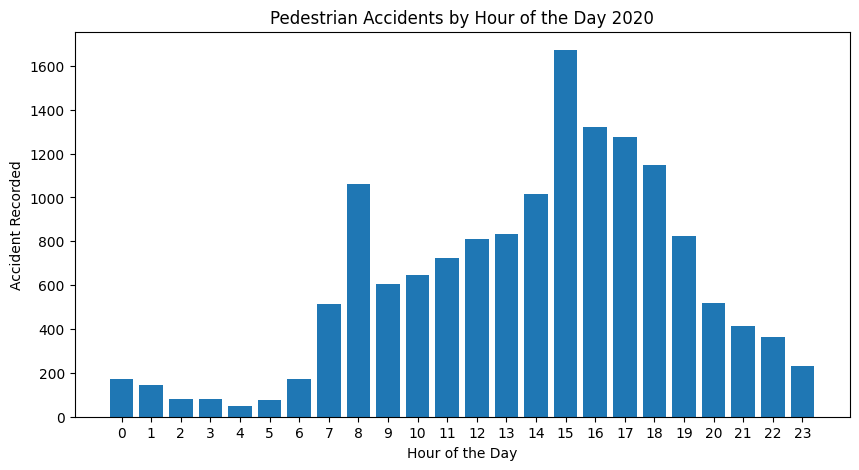

In [39]:
#  Plot of Motobike Accident by hour
plt.figure(figsize=(10, 5))
plt.bar(pedhourly_accident_counts.index, pedhourly_accident_counts.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Accident Recorded')
plt.title('Pedestrian Accidents by Hour of the Day 2020')

plt.xticks(range(24))
plt.show()



##### Pedestrian accident by days of the week

In [40]:
peddaily_accident_counts = pedestrianDF_with_timeDay['DayOfWeek'].value_counts().reindex(weekday_list)

In [41]:
# Pedestrian total accident per day of the week
peddaily_accident_counts.nlargest(7)

DayOfWeek
Friday       2543
Thursday     2366
Tuesday      2267
Wednesday    2247
Monday       2207
Saturday     1878
Sunday       1242
Name: count, dtype: int64

In [42]:
# group pedestrian data by day of the week, hour and age of casualty
pedGrouped_data = pedestrianDF_with_timeDay.groupby(['DayOfWeek', 'Hour','age_of_casualty']).size().reset_index(name='Count')

# checking for 20 ages with highest casualty
pedGrouped_data.nlargest(20,columns="Count")

,DayOfWeek,Hour,age_of_casualty,Count
5621,Tuesday,15,11,38
6675,Wednesday,15,11,37
4580,Thursday,15,12,32
1685,Monday,15,12,30
143,Friday,8,11,29
4579,Thursday,15,11,29
4133,Thursday,8,11,28
615,Friday,15,11,27
616,Friday,15,12,26
6676,Wednesday,15,12,23


### Plot of Pedestrian by day of the week

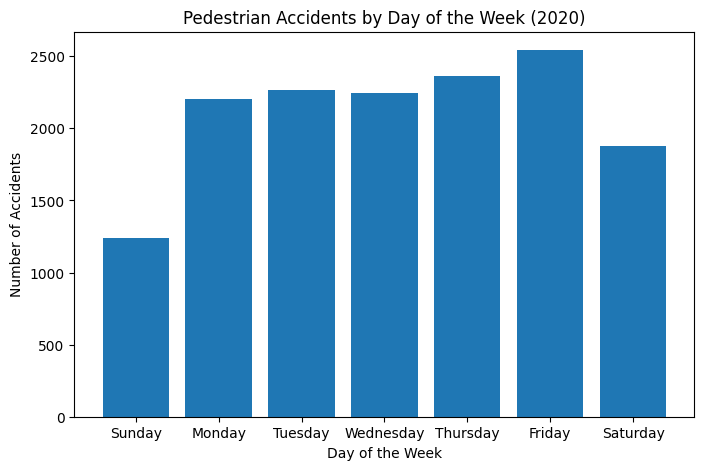

In [43]:
plt.figure(figsize=(8, 5))
plt.bar(weekday_list, peddaily_accident_counts.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.title('Pedestrian Accidents by Day of the Week (2020)')
plt.show()

#### 
#### 
#### 
##### Question 4 to 7 begins from here. firstly, I will select the records individually using the reusable function i have created to read from database and convert to pandas dataframe straight After this, I will then clean data with null values, negative value and strange entries using an helper function created below and other methods based on observation

In [44]:
# select 2020 data from accident table 
accidentDf = read_sql_to_pandas("select * from accident where accident_year = 2020")

In [45]:
# make a copy of accidentDf
accident_cp = accidentDf.copy()

In [46]:
# check about the structure of the table
accident_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

#### Cleaning Accident table

# Helper Function

##### I have written an helper function here to perform forward fill (ffill) or backward fill (bfill) on a specific column in a pandas DataFrame. It also includes an option to replace a particular value with NaN before performing the fill, and an option to convert the column's values to integer format if needed. I will use this function if I notice that there is a missing column or an incorrect entries and the column in the previous or after row follows the same pattern

In [47]:
# This function accepts dataframe, column to fill, type of fill(ffill by default), 
# rep_value mean the value to replace, var_type helps to know if its integer or not
def ffillBfillHelper(df,column,fill_type="ffill",rep_value=-1,var_type="integer"):
    try:
        df[f"{column}"].replace(rep_value, np.nan, inplace=True)
        # Forward fill the missing values in 'road_surface_conditions'
        df[f"{column}"].fillna(method=fill_type, inplace=True)
    
        if var_type == "integer":
            # Convert the values to integer format
            df[f"{column}"] = df[f"{column}"].astype(int)
        return df
    except Exception as exception_error:
        return exception_error
    return df


In [48]:
# check total null columns
accident_cp.isnull().sum()

accident_index                                  0
accident_year                                   0
accident_reference                              0
location_easting_osgr                          14
location_northing_osgr                         14
longitude                                      14
latitude                                       14
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_number                               0
road_type                                       0


In [49]:
# print out all columns in accident for better viewing
accident_cp.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')

In [50]:
# local_authority_highway was dropped due to its reduncant with local_authority_ons_district
# accident year was dropped because its of no use again since all the data is 2020
# accident reference also is thesame as accident index. the only difference is that
# accident index has 2020 appended to index
try:
    accident_cp.drop(['accident_year','accident_reference','local_authority_highway'], axis=1, inplace=True)
except Exception as ex:
    print("error!!!, The column may have been already dropped")

In [51]:
pd.set_option('display.max_columns',None)

In [52]:
# to fill in the missing, location_easting_osgr,location_northing_osgr
# longitude and latitude, i grouped the accident data by police_force and
# LOCAL AUTHORITY District below.
grouped_accident=accident_cp.groupby(['police_force','local_authority_ons_district' ])

In [53]:

# fill null values with nearest neighbour within the grouped police force
accident_dfn = grouped_accident[['location_easting_osgr', \
        'location_northing_osgr', 'longitude', 'latitude']].fillna(method="ffill")

In [54]:
# assign the filled null to their respective columns
accident_cp[['location_easting_osgr', \
        'location_northing_osgr', 'longitude', 'latitude']]=accident_cp[['location_easting_osgr', \
        'location_northing_osgr', 'longitude', 'latitude']].combine_first(accident_dfn)

In [55]:
accident_cp.isnull().sum()

accident_index                                 0
location_easting_osgr                          0
location_northing_osgr                         0
longitude                                      0
latitude                                       0
police_force                                   0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
date                                           0
day_of_week                                    0
time                                           0
local_authority_district                       0
local_authority_ons_district                   0
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                    0
junction_detail                                0
junction_control                               0
second_road_class   

In [56]:
# checking for unique values for road surface condition
accident_cp['road_surface_conditions'].unique()

array([ 9,  1,  2,  5,  4,  3, -1])

In [57]:
# in the above, -1 is not in the stat20 form hence the reason why it has to be cleaned
# checking where road surface condition is negative 
accident_cp.loc[accident_cp['road_surface_conditions']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
21032,2020030937290,297437.0,517966.0,-3.587037,54.546529,3,3,2,2,27/02/2020,5,16:50,63,E07000029,4,5345,6,30,3,4,6,0,0,0,1,9,-1,0,0,1,2,2,E01019280
21039,2020030939493,299302.0,516864.0,-3.557841,54.537004,3,3,1,1,06/03/2020,6,08:22,63,E07000029,6,0,6,30,0,-1,0,-1,0,0,1,9,-1,0,0,1,2,2,E01019284
21042,2020030939726,302614.0,525794.0,-3.509635,54.617876,3,3,2,1,12/03/2020,5,17:30,60,E07000026,3,595,6,60,0,-1,0,-1,0,0,1,9,-1,0,0,2,2,1,E01019101
21115,2020030951750,300076.0,510597.0,-3.543758,54.480859,3,2,1,1,30/04/2020,5,07:30,63,E07000029,6,0,6,30,0,-1,0,-1,0,0,1,9,-1,0,0,2,2,2,E01019275
21134,2020030954846,343036.0,553924.0,-2.889300,54.876823,3,3,2,1,20/05/2020,4,12:20,62,E07000028,6,0,6,30,3,4,6,0,0,0,1,9,-1,0,0,1,2,2,E01019213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86642,202063A017520,229280.0,212460.0,-4.476477,51.784694,63,3,2,1,26/02/2020,4,08:15,-1,W06000010,4,4298,6,50,0,-1,0,-1,0,0,1,9,-1,0,0,3,2,-1,-1
86774,202063A056020,244350.0,200870.0,-4.252999,51.684963,63,3,2,1,01/07/2020,4,23:00,751,W06000010,6,0,6,30,3,4,6,0,0,0,7,9,-1,0,0,2,2,-1,W01000711
87047,202063C034620,196200.0,236630.0,-4.969711,51.990646,63,3,2,1,09/07/2020,5,18:00,752,W06000009,6,0,6,30,3,4,6,0,0,0,1,9,-1,0,0,2,2,-1,W01000565
91094,2020991010132,226757.0,642246.0,-4.754274,55.642790,99,3,2,1,24/12/2020,5,21:30,931,S12000021,3,738,6,30,9,-1,6,0,-1,-1,4,8,-1,-1,-1,1,2,-1,-1


In [58]:
# checking to see the trend of road_surface_conditions tp determine
# what to use in repacing negative values
accident_cp[21028:21055]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
21028,2020030936452,300434.0,510081.0,-3.538061,54.476294,3,3,2,1,29/02/2020,7,18:55,63,E07000029,6,0,6,30,0,-1,0,-1,0,0,4,1,1,0,0,2,1,2,E01019275
21029,2020030936543,347645.0,526067.0,-2.812449,54.627017,3,3,1,1,23/02/2020,1,11:30,64,E07000030,3,592,6,60,0,-1,0,-1,0,0,1,1,1,0,0,2,2,2,E01019311
21030,2020030937104,320330.0,470186.0,-3.220448,54.121347,3,3,1,1,13/02/2020,5,16:00,61,E07000027,6,0,6,30,9,4,6,0,0,0,1,9,1,0,0,1,2,2,E01019170
21031,2020030937215,322540.0,471023.0,-3.186859,54.129207,3,3,2,1,26/02/2020,4,17:00,61,E07000027,6,0,6,60,0,-1,0,-1,0,0,6,1,2,7,0,2,2,2,E01019179
21032,2020030937290,297437.0,517966.0,-3.587037,54.546529,3,3,2,2,27/02/2020,5,16:50,63,E07000029,4,5345,6,30,3,4,6,0,0,0,1,9,-1,0,0,1,2,2,E01019280
21033,2020030937334,341286.0,498675.0,-2.905470,54.380178,3,2,1,1,06/03/2020,6,08:50,65,E07000031,3,5074,6,30,9,4,6,0,0,0,1,1,1,0,0,2,1,2,E01019395
21034,2020030937794,360309.0,478596.0,-2.609939,54.201578,3,3,2,1,06/03/2020,6,18:40,65,E07000031,4,6446,6,40,3,4,3,65,0,0,6,1,1,0,0,2,1,2,E01019373
21035,2020030937857,298281.0,517319.0,-3.573771,54.540887,3,3,1,1,07/03/2020,7,05:25,63,E07000029,3,595,6,40,0,-1,0,-1,0,0,4,1,2,0,0,1,1,1,E01019281
21036,2020030937882,320892.0,470775.0,-3.212007,54.126727,3,2,2,1,08/03/2020,1,17:00,61,E07000027,6,0,6,30,0,-1,0,-1,0,0,1,1,1,0,0,1,1,2,E01019169
21037,2020030937903,358064.0,490267.0,-2.645990,54.306282,3,3,1,1,08/03/2020,1,08:35,65,E07000031,1,6,3,70,0,-1,0,-1,0,0,1,1,1,0,0,2,1,1,E01019394


In [59]:
accident_cp[21028:21039]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
21028,2020030936452,300434.0,510081.0,-3.538061,54.476294,3,3,2,1,29/02/2020,7,18:55,63,E07000029,6,0,6,30,0,-1,0,-1,0,0,4,1,1,0,0,2,1,2,E01019275
21029,2020030936543,347645.0,526067.0,-2.812449,54.627017,3,3,1,1,23/02/2020,1,11:30,64,E07000030,3,592,6,60,0,-1,0,-1,0,0,1,1,1,0,0,2,2,2,E01019311
21030,2020030937104,320330.0,470186.0,-3.220448,54.121347,3,3,1,1,13/02/2020,5,16:00,61,E07000027,6,0,6,30,9,4,6,0,0,0,1,9,1,0,0,1,2,2,E01019170
21031,2020030937215,322540.0,471023.0,-3.186859,54.129207,3,3,2,1,26/02/2020,4,17:00,61,E07000027,6,0,6,60,0,-1,0,-1,0,0,6,1,2,7,0,2,2,2,E01019179
21032,2020030937290,297437.0,517966.0,-3.587037,54.546529,3,3,2,2,27/02/2020,5,16:50,63,E07000029,4,5345,6,30,3,4,6,0,0,0,1,9,-1,0,0,1,2,2,E01019280
21033,2020030937334,341286.0,498675.0,-2.905470,54.380178,3,2,1,1,06/03/2020,6,08:50,65,E07000031,3,5074,6,30,9,4,6,0,0,0,1,1,1,0,0,2,1,2,E01019395
21034,2020030937794,360309.0,478596.0,-2.609939,54.201578,3,3,2,1,06/03/2020,6,18:40,65,E07000031,4,6446,6,40,3,4,3,65,0,0,6,1,1,0,0,2,1,2,E01019373
21035,2020030937857,298281.0,517319.0,-3.573771,54.540887,3,3,1,1,07/03/2020,7,05:25,63,E07000029,3,595,6,40,0,-1,0,-1,0,0,4,1,2,0,0,1,1,1,E01019281
21036,2020030937882,320892.0,470775.0,-3.212007,54.126727,3,2,2,1,08/03/2020,1,17:00,61,E07000027,6,0,6,30,0,-1,0,-1,0,0,1,1,1,0,0,1,1,2,E01019169
21037,2020030937903,358064.0,490267.0,-2.645990,54.306282,3,3,1,1,08/03/2020,1,08:35,65,E07000031,1,6,3,70,0,-1,0,-1,0,0,1,1,1,0,0,2,1,1,E01019394


###### replace road_surface_conditions,weather_conditions,light_conditions,pedestrian_crossing_physical_facilities,
###### did_police_officer_attend_scene_of_accident and junction_control with forward fill because they follows a particular trend for example most previous and later entries are 1 then the next one should be 1

In [60]:
# declare columns to ffill and bfill based on observation
columns_tofBfill = [
                {"name":"road_surface_conditions",
                  "fill_type":"ffill",
                 },
                 {"name":"weather_conditions",
                  "fill_type":"ffill",
                 },
                 {"name":"light_conditions",
                  "fill_type":"ffill",
                 },
                 {"name":"pedestrian_crossing_physical_facilities",
                  "fill_type":"bfill",
                 },
                 {"name":"did_police_officer_attend_scene_of_accident",
                  "fill_type":"bfill",
                 },
                 {"name":"junction_control",
                  "fill_type":"bfill",
                 },
                 {"name":"second_road_number",
                  "fill_type":"bfill",
                 },
                 {"name":"special_conditions_at_site",
                  "fill_type":"bfill",
                 },
                 {"name":"carriageway_hazards",
                  "fill_type":"bfill",
                 },{"name":"local_authority_district",
                  "fill_type":"bfill",
                 },{"name":"special_conditions_at_site",
                  "fill_type":"bfill",
                 },{"name":"pedestrian_crossing_human_control",
                  "fill_type":"bfill",
                 }

                ]

In [61]:
# looping through the observed negative columns that follow thesame trend
# e.g previous values and after values are mostly 1,1,-1,1 or 2,2,2,1,1,2

for column in columns_tofBfill:
    
    ffillBfillHelper(accident_cp,
                 column["name"],
                 column["fill_type"],
                 -1,
                 "integer")

In [62]:
accident_cp.loc[accident_cp['weather_conditions']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [63]:
# checking to see if there is any more negative 
accident_cp.loc[accident_cp['road_surface_conditions']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [64]:
accident_cp.loc[accident_cp['weather_conditions']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [65]:
accident_cp[79770:79788]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
79770,2020520002373,352593.0,121000.0,-2.676769,50.986432,52,3,2,3,28/02/2020,6,13:52,610,E07000189,3,37,6,60,9,4.0,6,0.0,0,0,1,2,2,0,0,2,1,2,E01029214
79771,2020520002383,325473.0,124892.0,-3.063886,51.018548,52,3,2,1,13/06/2020,7,15:05,608,E07000190,6,0,1,30,1,2.0,6,0.0,0,0,1,2,2,1,0,2,2,2,E01029317
79772,2020520002412,349822.0,127665.0,-2.717169,51.046126,52,3,2,1,10/06/2020,4,09:45,610,E07000189,4,3151,6,40,9,4.0,6,0.0,0,0,1,1,1,0,0,2,1,2,E01029224
79773,2020520002424,312970.0,119423.0,-3.240786,50.967621,52,3,1,1,18/06/2020,5,11:30,608,E07000190,6,0,6,60,0,4.0,0,358.0,0,0,1,2,2,0,0,2,2,2,E01029314
79774,2020520002461,353053.0,115766.0,-2.669538,50.939407,52,3,2,1,22/06/2020,2,06:40,610,E07000189,6,0,6,40,0,4.0,0,358.0,0,0,1,1,1,0,0,2,2,2,E01029245
79775,2020520002465,347531.0,136272.0,-2.751100,51.123309,52,3,2,1,19/06/2020,6,20:15,606,E07000187,6,0,6,30,0,4.0,0,358.0,0,0,1,1,1,0,0,1,2,2,E01029070
79776,2020520002484,361738.0,151128.0,-2.549697,51.258017,52,3,2,2,23/05/2020,7,19:09,606,E07000187,4,3139,6,60,0,4.0,0,358.0,2,0,1,1,1,0,0,2,1,2,E01029018
79777,2020520002488,343681.0,154706.0,-2.809007,51.288686,52,1,1,1,24/06/2020,4,01:15,610,E07000188,3,371,6,60,0,4.0,0,358.0,0,0,1,1,1,0,0,2,2,2,E01029085
79778,2020520002490,334343.0,115367.0,-2.935724,50.933989,52,3,2,2,24/06/2020,4,21:30,610,E07000189,3,303,9,60,1,4.0,3,358.0,0,0,7,1,1,0,0,2,2,1,E01029208
79779,2020520002492,328729.0,133091.0,-3.019091,51.092676,52,3,2,1,25/06/2020,5,08:50,608,E07000188,6,0,6,30,3,4.0,6,0.0,0,0,1,1,1,0,0,2,2,2,E01029143


In [66]:
# checking to see if there is any more negative 
accident_cp.loc[accident_cp['weather_conditions']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [67]:
# checking to see if there is any more negative
accident_cp.loc[accident_cp['light_conditions']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [68]:
# checking to see if there is any more negative
accident_cp.loc[accident_cp['pedestrian_crossing_physical_facilities']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [69]:
# checking to see if there is any more negative
accident_cp.loc[accident_cp['did_police_officer_attend_scene_of_accident']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [70]:
# checking to see if there is any more negative
accident_cp.loc[accident_cp['junction_control']==-1]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location


In [71]:
accident_cp["junction_control"].fillna(method='bfill', inplace=True)

In [72]:
accident_cp.loc[accident_cp["junction_control"].isnull()]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
91198,2020991032575,240402.0,681950.0,-4.56104,56.003843,99,3,1,1,25/08/2020,3,13:50,916,S12000039,6,0,6,30,0,NaN,0,NaN,0,0,1,1,1,0,2,1,1,-1,-1


In [73]:
accident_cp[91196:91205]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
91196,2020991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,1,15/04/2020,4,12:42,910,S12000033,4,979,6,60,8,4.0,6,0.0,0,0,1,1,1,0,0,2,1,-1,-1
91197,2020991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,1,15/12/2020,3,14:00,932,S12000044,6,0,6,30,3,4.0,6,0.0,0,0,1,1,1,0,0,1,2,-1,-1
91198,2020991032575,240402.0,681950.0,-4.561040,56.003843,99,3,1,1,25/08/2020,3,13:50,916,S12000039,6,0,6,30,0,NaN,0,NaN,0,0,1,1,1,0,2,1,1,-1,-1


In [74]:
accident_cp["junction_control"].replace([np.inf, -np.inf], np.nan, inplace=True)
accident_cp["junction_control"].fillna(-1, inplace=True)

accident_cp["junction_control"] = accident_cp["junction_control"].astype(int)


accident_cp["second_road_number"].replace([np.inf, -np.inf], np.nan, inplace=True)
accident_cp["second_road_number"].fillna(-1, inplace=True)
accident_cp["second_road_number"] = accident_cp["second_road_number"].astype(int)



In [75]:
accident_cp[79770:79790]

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
79770,2020520002373,352593.0,121000.0,-2.676769,50.986432,52,3,2,3,28/02/2020,6,13:52,610,E07000189,3,37,6,60,9,4,6,0,0,0,1,2,2,0,0,2,1,2,E01029214
79771,2020520002383,325473.0,124892.0,-3.063886,51.018548,52,3,2,1,13/06/2020,7,15:05,608,E07000190,6,0,1,30,1,2,6,0,0,0,1,2,2,1,0,2,2,2,E01029317
79772,2020520002412,349822.0,127665.0,-2.717169,51.046126,52,3,2,1,10/06/2020,4,09:45,610,E07000189,4,3151,6,40,9,4,6,0,0,0,1,1,1,0,0,2,1,2,E01029224
79773,2020520002424,312970.0,119423.0,-3.240786,50.967621,52,3,1,1,18/06/2020,5,11:30,608,E07000190,6,0,6,60,0,4,0,358,0,0,1,2,2,0,0,2,2,2,E01029314
79774,2020520002461,353053.0,115766.0,-2.669538,50.939407,52,3,2,1,22/06/2020,2,06:40,610,E07000189,6,0,6,40,0,4,0,358,0,0,1,1,1,0,0,2,2,2,E01029245
79775,2020520002465,347531.0,136272.0,-2.751100,51.123309,52,3,2,1,19/06/2020,6,20:15,606,E07000187,6,0,6,30,0,4,0,358,0,0,1,1,1,0,0,1,2,2,E01029070
79776,2020520002484,361738.0,151128.0,-2.549697,51.258017,52,3,2,2,23/05/2020,7,19:09,606,E07000187,4,3139,6,60,0,4,0,358,2,0,1,1,1,0,0,2,1,2,E01029018
79777,2020520002488,343681.0,154706.0,-2.809007,51.288686,52,1,1,1,24/06/2020,4,01:15,610,E07000188,3,371,6,60,0,4,0,358,0,0,1,1,1,0,0,2,2,2,E01029085
79778,2020520002490,334343.0,115367.0,-2.935724,50.933989,52,3,2,2,24/06/2020,4,21:30,610,E07000189,3,303,9,60,1,4,3,358,0,0,7,1,1,0,0,2,2,1,E01029208
79779,2020520002492,328729.0,133091.0,-3.019091,51.092676,52,3,2,1,25/06/2020,5,08:50,608,E07000188,6,0,6,30,3,4,6,0,0,0,1,1,1,0,0,2,2,2,E01029143


#### 
#### 
#### Cleaning Casualty table  

In [76]:
casualty_df = read_sql_to_pandas("select * from casualty where accident_year = 2020")

In [77]:
casualty_df

,casualty_index,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,484748,2020010219808,2020,010219808,1,1,3,1,31,6,3,9,5,0,0,0,0,1,4
1,484749,2020010220496,2020,010220496,1,1,3,2,2,1,3,1,1,0,0,0,0,1,2
2,484750,2020010220496,2020,010220496,1,2,3,2,4,1,3,1,1,0,0,0,0,1,2
3,484751,2020010228005,2020,010228005,1,1,3,1,23,5,3,5,9,0,0,0,0,1,3
4,484752,2020010228006,2020,010228006,1,1,3,1,47,8,2,4,1,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115579,600327,2020991027064,2020,991027064,2,1,1,1,11,3,2,0,0,0,0,0,1,1,2
115580,600328,2020991029573,2020,991029573,1,1,3,2,63,9,3,10,1,0,0,0,0,1,10
115581,600329,2020991030297,2020,991030297,2,1,1,1,38,7,2,0,0,0,0,0,5,2,9
115582,600330,2020991030900,2020,991030900,2,1,1,1,76,11,3,0,0,0,0,0,1,1,9


In [78]:
# make a copy of vehicle df 
casualty_cp = casualty_df[:]

##### I will be dropping the following columns because they have replica in another table I am doing this to avoid Multicollinearity and redundancy

In [79]:
# I will be dropping the following columns because they have replica in another table
# I am doing this to avoid Multicollinearity and redundancy
try:
    casualty_cp.drop(['accident_year','accident_reference',
                      'vehicle_reference','casualty_reference',
                      'casualty_severity','age_band_of_casualty'], axis=1, inplace=True)
except Exception as ex:
    print(ex)

In [80]:
casualty_cp.isnull().sum()

casualty_index                        0
accident_index                        0
casualty_class                        0
sex_of_casualty                       0
age_of_casualty                       0
pedestrian_location                   0
pedestrian_movement                   0
car_passenger                         0
bus_or_coach_passenger                0
pedestrian_road_maintenance_worker    0
casualty_type                         0
casualty_home_area_type               0
casualty_imd_decile                   0
dtype: int64

In [81]:
casualty_cp["sex_of_casualty"].unique()

array([ 1,  2, -1,  9])

##### As seen in the above unique sex of casualty, we have 9 and -1 and according to the stats19 form, we only have sex of casualty as 1 and 2 meaning male and female. Having studied the pattern of the sex of casualty from the data frame, foward and backward fill will be the best in fixing these errors


In [82]:
casualty_cp.loc[casualty_cp["sex_of_casualty"]==9]

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
79064,563812,2020430055987,2,9,14,0,0,2,0,0,9,-1,-1
79065,563813,2020430055987,2,9,14,0,0,2,0,0,9,-1,-1
79921,564669,2020430173231,2,9,11,0,0,2,0,0,9,1,5
79922,564670,2020430173231,2,9,8,0,0,1,0,0,9,1,5
80153,564901,2020430204523,2,9,-1,0,0,0,4,0,11,-1,-1


In [83]:
casualty_cp.loc[casualty_cp["sex_of_casualty"]==-1].head()

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
18,484766,2020010228031,2,-1,-1,0,0,1,0,0,9,1,1
47,484795,2020010228155,2,-1,-1,0,0,9,0,0,9,-1,-1
48,484796,2020010228155,2,-1,-1,0,0,1,0,0,9,-1,-1
61,484809,2020010228211,2,-1,-1,0,0,1,0,0,9,1,3
139,484887,2020010228461,2,-1,-1,0,0,2,0,0,9,1,7


In [84]:
ffillBfillHelper(casualty_cp,
                 "sex_of_casualty",
                 "ffill",
                 [-1, 9],
                 "integer") 

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,484748,2020010219808,3,1,31,9,5,0,0,0,0,1,4
1,484749,2020010220496,3,2,2,1,1,0,0,0,0,1,2
2,484750,2020010220496,3,2,4,1,1,0,0,0,0,1,2
3,484751,2020010228005,3,1,23,5,9,0,0,0,0,1,3
4,484752,2020010228006,3,1,47,4,1,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115579,600327,2020991027064,1,1,11,0,0,0,0,0,1,1,2
115580,600328,2020991029573,3,2,63,10,1,0,0,0,0,1,10
115581,600329,2020991030297,1,1,38,0,0,0,0,0,5,2,9
115582,600330,2020991030900,1,1,76,0,0,0,0,0,1,1,9


In [85]:
casualty_cp.loc[casualty_cp["sex_of_casualty"]==-1].head()

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile


In [86]:
casualty_cp.loc[casualty_cp["sex_of_casualty"]==9].head()

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile


In [87]:
casualty_cp.loc[casualty_cp["age_of_casualty"]==-1].head()

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
12,484760,2020010228022,1,1,-1,0,0,0,0,0,9,-1,-1
18,484766,2020010228031,2,1,-1,0,0,1,0,0,9,1,1
47,484795,2020010228155,2,2,-1,0,0,9,0,0,9,-1,-1
48,484796,2020010228155,2,2,-1,0,0,1,0,0,9,-1,-1
61,484809,2020010228211,2,2,-1,0,0,1,0,0,9,1,3


In [88]:
# checking the ages before and after 
casualty_cp[8:20]

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
8,484756,2020010228014,1,1,41,0,0,0,0,0,9,1,3
9,484757,2020010228017,3,1,50,9,9,0,0,0,0,1,3
10,484758,2020010228018,1,1,62,0,0,0,0,0,9,1,6
11,484759,2020010228020,1,1,37,0,0,0,0,0,3,1,8
12,484760,2020010228022,1,1,-1,0,0,0,0,0,9,-1,-1
13,484761,2020010228024,1,1,33,0,0,0,0,0,9,1,6
14,484762,2020010228024,2,2,20,0,0,1,0,0,9,-1,-1
15,484763,2020010228024,1,1,41,0,0,0,0,0,9,1,4
16,484764,2020010228024,2,2,42,0,0,1,0,0,9,1,4
17,484765,2020010228031,1,1,30,0,0,0,0,0,9,1,2


##### In the 'age of casualty' column, there are negative entries for age (-1). After examining the 'casualty class' column, I noticed that the classes are either 'driver' or 'pillion passenger.' These classes are expected to be adults. Therefore, to handle the negative age entries, I will fill them with the mean age of the adults.

In [89]:
# Calculate the mean age (excluding -1) to avoid bias
mean_age = casualty_cp[casualty_cp['age_of_casualty'] != -1]['age_of_casualty'].mean()

# Replace -1 with the mean age
casualty_cp['age_of_casualty'].replace(-1, int(mean_age), inplace=True)

In [90]:
casualty_cp.loc[casualty_cp["age_of_casualty"]==-1]

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile


In [91]:
casualty_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115584 entries, 0 to 115583
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   casualty_index                      115584 non-null  int64 
 1   accident_index                      115584 non-null  object
 2   casualty_class                      115584 non-null  int64 
 3   sex_of_casualty                     115584 non-null  int64 
 4   age_of_casualty                     115584 non-null  int64 
 5   pedestrian_location                 115584 non-null  int64 
 6   pedestrian_movement                 115584 non-null  int64 
 7   car_passenger                       115584 non-null  int64 
 8   bus_or_coach_passenger              115584 non-null  int64 
 9   pedestrian_road_maintenance_worker  115584 non-null  int64 
 10  casualty_type                       115584 non-null  int64 
 11  casualty_home_area_type             115

In [92]:
casualty_cp['pedestrian_location'].unique()

array([ 9,  1,  5,  4,  6,  0, 10,  8,  7,  3,  2, -1])

In [93]:
casualty_cp.head(10)

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,484748,2020010219808,3,1,31,9,5,0,0,0,0,1,4
1,484749,2020010220496,3,2,2,1,1,0,0,0,0,1,2
2,484750,2020010220496,3,2,4,1,1,0,0,0,0,1,2
3,484751,2020010228005,3,1,23,5,9,0,0,0,0,1,3
4,484752,2020010228006,3,1,47,4,1,0,0,0,0,1,3
5,484753,2020010228011,3,2,32,6,9,0,0,0,0,1,8
6,484754,2020010228011,3,2,33,6,9,0,0,0,0,-1,-1
7,484755,2020010228012,1,1,25,0,0,0,0,0,9,1,4
8,484756,2020010228014,1,1,41,0,0,0,0,0,9,1,3
9,484757,2020010228017,3,1,50,9,9,0,0,0,0,1,3


In [94]:
casualty_cp.loc[casualty_cp['pedestrian_location']==-1]

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
67594,552342,2020350954316,3,1,12,-1,-1,0,0,-1,0,1,3
93648,578396,2020470928001,3,1,58,-1,-1,0,0,-1,0,1,10


In [95]:
# checking for values before and after

casualty_cp[67590:67599]

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
67590,552338,2020350954183,1,1,39,0,0,0,0,0,9,2,10
67591,552339,2020350954272,2,2,62,0,0,-1,0,0,8,1,9
67592,552340,2020350954272,2,2,27,0,0,-1,0,0,8,1,1
67593,552341,2020350954310,1,2,42,0,0,0,0,0,1,1,5
67594,552342,2020350954316,3,1,12,-1,-1,0,0,-1,0,1,3
67595,552343,2020350954352,1,1,49,0,0,0,0,0,4,1,6
67596,552344,2020350954373,1,1,24,0,0,0,0,0,3,1,5
67597,552345,2020350954614,1,2,62,0,0,0,0,0,9,2,7
67598,552346,2020350954873,3,2,7,5,3,0,0,0,0,3,8


In [96]:
# checking for unique entries
casualty_cp['bus_or_coach_passenger'].unique()

array([ 0,  4,  3,  1,  2,  9, -1])

In [97]:
casualty_cp.loc[casualty_cp['bus_or_coach_passenger']==-1].head()

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
25066,509814,2020031001490,2,1,37,0,0,0,-1,0,11,-1,-1
35942,520690,2020100935233,2,1,0,0,0,0,-1,0,11,1,4
36076,520824,2020100941735,2,2,73,0,0,0,-1,0,11,1,2
37961,522709,2020110962004,2,1,59,0,0,0,-1,0,11,2,4
43984,528732,2020140931818,2,2,37,0,0,0,-1,0,11,1,9


In [98]:
# declare columns to ffill and bfill based on observation
casualtyColumns_tofBfill = [
                {"name":"pedestrian_location",
                  "fill_type":"ffill",
                 },
                 {"name":"pedestrian_location",
                  "fill_type":"ffill",
                 },
                 {"name":"car_passenger",
                  "fill_type":"ffill",
                 },
                 {"name":"bus_or_coach_passenger",
                  "fill_type":"ffill",
                 },
                 {"name":"casualty_home_area_type",
                  "fill_type":"ffill",
                 },
                ]

In [99]:
# looping through the observed negative columns that follow thesame trend
# e.g previous values and after values are mostly 1,1,-1,1 or 2,2,2,1,1,2

for column in casualtyColumns_tofBfill:
    
    ffillBfillHelper(casualty_cp,
                 column["name"],
                 column["fill_type"],
                 -1,
                 "integer")

In [100]:
# checking to see if the negatives have be resolved
casualty_cp[25060:25069]

,casualty_index,accident_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
25060,509808,2020031001149,1,1,47,0,0,0,0,0,9,1,7
25061,509809,2020031001204,1,2,69,0,0,0,0,0,9,3,5
25062,509810,2020031001423,2,2,17,0,0,1,0,0,9,1,2
25063,509811,2020031001460,2,1,23,0,0,1,0,0,9,1,3
25064,509812,2020031001460,1,1,18,0,0,0,0,0,9,2,4
25065,509813,2020031001460,2,1,18,0,0,2,0,0,9,3,6
25066,509814,2020031001490,2,1,37,0,0,0,0,0,11,3,-1
25067,509815,2020031002101,1,1,59,0,0,0,0,0,9,3,3
25068,509816,2020031002173,3,2,11,5,1,0,0,0,0,1,8


###### 
######  
###### 
###### Vehicle Reading and  Cleaning

In [101]:
# reading vehicle to daatafram using the reusable function
# I created
vehicle_df = read_sql_to_pandas("select * from vehicle where accident_year = 2020")

In [102]:
# checking the first 5 records
vehicle_df.head()

,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,681716,2020010219808,2020,010219808,1,9,9,5,1,5,0,0,0,0,0,0,4,9,6,2,32,6,1968,2,6,AUDI Q5,4,1
1,681717,2020010220496,2020,010220496,1,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1,45,7,1395,1,2,AUDI A1,7,1
2,681718,2020010228005,2020,010228005,1,9,0,18,-1,-1,0,0,0,0,0,0,1,1,6,3,-1,-1,-1,-1,-1,-1,-1,-1
3,681719,2020010228006,2020,010228006,1,8,0,18,1,5,0,0,0,0,0,0,1,1,1,1,44,7,1798,8,8,TOYOTA PRIUS,2,1
4,681720,2020010228011,2020,010228011,1,9,0,18,3,7,9,1,0,0,0,0,1,1,6,1,20,4,2993,2,4,BMW 4 SERIES,-1,-1


In [103]:
# make a copy to work with
vehicle_cp = vehicle_df[:]

In [104]:
vehicle_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167375 entries, 0 to 167374
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     167375 non-null  int64 
 1   accident_index                    167375 non-null  object
 2   accident_year                     167375 non-null  int64 
 3   accident_reference                167375 non-null  object
 4   vehicle_reference                 167375 non-null  int64 
 5   vehicle_type                      167375 non-null  int64 
 6   towing_and_articulation           167375 non-null  int64 
 7   vehicle_manoeuvre                 167375 non-null  int64 
 8   vehicle_direction_from            167375 non-null  int64 
 9   vehicle_direction_to              167375 non-null  int64 
 10  vehicle_location_restricted_lane  167375 non-null  int64 
 11  junction_location                 167375 non-null  int64 
 12  sk

In [105]:
# checking to see the columns and aswell if there is any null
vehicle_cp.isnull().sum()

vehicle_index                       0
accident_index                      0
accident_year                       0
accident_reference                  0
vehicle_reference                   0
vehicle_type                        0
towing_and_articulation             0
vehicle_manoeuvre                   0
vehicle_direction_from              0
vehicle_direction_to                0
vehicle_location_restricted_lane    0
junction_location                   0
skidding_and_overturning            0
hit_object_in_carriageway           0
vehicle_leaving_carriageway         0
hit_object_off_carriageway          0
first_point_of_impact               0
vehicle_left_hand_drive             0
journey_purpose_of_driver           0
sex_of_driver                       0
age_of_driver                       0
age_band_of_driver                  0
engine_capacity_cc                  0
propulsion_code                     0
age_of_vehicle                      0
generic_make_model                  0
driver_imd_d

##### I will be dropping the following columns because they have replica in another table I am doing this to avoid Multicollinearity and redundancy

In [106]:
# I will be dropping the following columns because they have replica in another table
# I am doing this to avoid Multicollinearity and redundancy
vehicle_cp.drop(['accident_year','accident_reference','vehicle_reference','driver_imd_decile','driver_home_area_type','age_band_of_driver','age_of_driver','sex_of_driver'], axis=1, inplace=True)

In [107]:
vehicle_cp.isnull().sum()

vehicle_index                       0
accident_index                      0
vehicle_type                        0
towing_and_articulation             0
vehicle_manoeuvre                   0
vehicle_direction_from              0
vehicle_direction_to                0
vehicle_location_restricted_lane    0
junction_location                   0
skidding_and_overturning            0
hit_object_in_carriageway           0
vehicle_leaving_carriageway         0
hit_object_off_carriageway          0
first_point_of_impact               0
vehicle_left_hand_drive             0
journey_purpose_of_driver           0
engine_capacity_cc                  0
propulsion_code                     0
age_of_vehicle                      0
generic_make_model                  0
dtype: int64

In [108]:
vehicle_cp

,vehicle_index,accident_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model
0,681716,2020010219808,9,9,5,1,5,0,0,0,0,0,0,4,9,6,1968,2,6,AUDI Q5
1,681717,2020010220496,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1395,1,2,AUDI A1
2,681718,2020010228005,9,0,18,-1,-1,0,0,0,0,0,0,1,1,6,-1,-1,-1,-1
3,681719,2020010228006,8,0,18,1,5,0,0,0,0,0,0,1,1,1,1798,8,8,TOYOTA PRIUS
4,681720,2020010228011,9,0,18,3,7,9,1,0,0,0,0,1,1,6,2993,2,4,BMW 4 SERIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167370,849086,2020991030297,9,0,7,8,2,0,6,0,0,0,0,3,1,1,1968,2,2,AUDI A5
167371,849087,2020991030297,5,0,16,6,2,0,1,0,0,0,0,1,1,5,1301,1,2,KTM 1290 SUPERDUKE
167372,849088,2020991030900,9,0,7,8,2,0,6,0,0,0,0,3,1,6,1995,2,1,BMW X3
167373,849089,2020991030900,1,0,18,6,2,4,8,0,0,0,0,1,1,6,-1,-1,-1,-1


In [109]:

# replace negative vehicle age with mean
# Calculate the mean age (excluding -1) to avoid bias
vehicle_mean_age = vehicle_cp[vehicle_cp['age_of_vehicle'] != -1]['age_of_vehicle'].mean()

# Replace -1 with the mean age
vehicle_cp['age_of_vehicle'].replace(-1, int(vehicle_mean_age), inplace=True)

In [110]:
# replace negative vehicle make model with Unknown

# string "-1" was seen as string in the column hence the reason 
# why i filtered with stringed -1
vehicle_cp['generic_make_model'].replace("-1", "Unknown", inplace=True)

In [111]:
# declare columns to ffill and bfill based on observation of the trend
vehicleColumns_tofBfill = [
                {"name":"vehicle_direction_from",
                  "fill_type":"ffill",
                 },
                 {"name":"vehicle_direction_to",
                  "fill_type":"ffill",
                 },
                 {"name":"engine_capacity_cc",
                  "fill_type":"ffill",
                 },
                 {"name":"propulsion_code",
                  "fill_type":"ffill",
                 }
                ]
# looping through the observed negative columns that follow thesame trend
# e.g previous values and after values are mostly 1,1,-1,1 or 2,2,2,1,1,2

for column in vehicleColumns_tofBfill:
    
    ffillBfillHelper(vehicle_cp,
                 column["name"],
                 column["fill_type"],
                 -1,
                 "integer")

In [112]:
vehicle_cp

,vehicle_index,accident_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model
0,681716,2020010219808,9,9,5,1,5,0,0,0,0,0,0,4,9,6,1968,2,6,AUDI Q5
1,681717,2020010220496,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1395,1,2,AUDI A1
2,681718,2020010228005,9,0,18,2,6,0,0,0,0,0,0,1,1,6,1395,1,8,Unknown
3,681719,2020010228006,8,0,18,1,5,0,0,0,0,0,0,1,1,1,1798,8,8,TOYOTA PRIUS
4,681720,2020010228011,9,0,18,3,7,9,1,0,0,0,0,1,1,6,2993,2,4,BMW 4 SERIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167370,849086,2020991030297,9,0,7,8,2,0,6,0,0,0,0,3,1,1,1968,2,2,AUDI A5
167371,849087,2020991030297,5,0,16,6,2,0,1,0,0,0,0,1,1,5,1301,1,2,KTM 1290 SUPERDUKE
167372,849088,2020991030900,9,0,7,8,2,0,6,0,0,0,0,3,1,6,1995,2,1,BMW X3
167373,849089,2020991030900,1,0,18,6,2,4,8,0,0,0,0,1,1,6,1995,2,8,Unknown


##### 
##### 
##### 
##### 
## 4. Using the apriori algorithm, explore the impact of selected variables on accident severity.  

#### firstly, i will be merging accident, casualty and vehicles table together for this analysis

In [113]:
merged_df = pd.merge(accident_cp, vehicle_cp, on='accident_index', how='inner')

In [114]:
merged_dataF= pd.merge(merged_df,casualty_cp, on='accident_index', how='inner')

In [115]:
# Extract the hour from the 'Time' column
merged_dataF['Hour'] = merged_dataF['time'].str.extract(r'(\d+):').astype(int)

In [116]:
merged_dataF.head()

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,vehicle_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,casualty_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,Hour
0,2020010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,1,04/02/2020,3,09:00,10,E09000032,6,0,6,20,0,2,0,0,9,9,1,9,9,0,0,1,3,2,E01004576,681716,9,9,5,1,5,0,0,0,0,0,0,4,9,6,1968,2,6,AUDI Q5,484748,3,1,31,9,5,0,0,0,0,1,4,9
1,2020010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,2,27/04/2020,2,13:55,9,E09000022,3,3036,6,20,9,2,6,0,0,4,1,1,1,0,0,1,1,2,E01003034,681717,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1395,1,2,AUDI A1,484749,3,2,2,1,1,0,0,0,0,1,2,13
2,2020010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,2,27/04/2020,2,13:55,9,E09000022,3,3036,6,20,9,2,6,0,0,4,1,1,1,0,0,1,1,2,E01003034,681717,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1395,1,2,AUDI A1,484750,3,2,4,1,1,0,0,0,0,1,2,13
3,2020010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,1,01/01/2020,4,01:25,1,E09000033,5,0,6,30,3,1,6,0,0,0,4,1,2,0,0,1,1,2,E01004726,681718,9,0,18,2,6,0,0,0,0,0,0,1,1,6,1395,1,8,Unknown,484751,3,1,23,5,9,0,0,0,0,1,3,1
4,2020010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,1,01/01/2020,4,01:50,17,E09000025,3,11,6,30,0,4,0,0,0,4,4,1,1,0,0,1,1,2,E01003617,681719,8,0,18,1,5,0,0,0,0,0,0,1,1,1,1798,8,8,TOYOTA PRIUS,484752,3,1,47,4,1,0,0,0,0,1,3,1


In [117]:
numerical_df = merged_dataF.select_dtypes(include='number')
numerical_df.head()

,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,vehicle_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,casualty_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,Hour
0,521389.0,175144.0,-0.254001,51.462262,1,3,1,1,3,10,6,0,6,20,0,2,0,0,9,9,1,9,9,0,0,1,3,2,681716,9,9,5,1,5,0,0,0,0,0,0,4,9,6,1968,2,6,484748,3,1,31,9,5,0,0,0,0,1,4,9
1,529337.0,176237.0,-0.139253,51.470327,1,3,1,2,2,9,3,3036,6,20,9,2,6,0,0,4,1,1,1,0,0,1,1,2,681717,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1395,1,2,484749,3,2,2,1,1,0,0,0,0,1,2,13
2,529337.0,176237.0,-0.139253,51.470327,1,3,1,2,2,9,3,3036,6,20,9,2,6,0,0,4,1,1,1,0,0,1,1,2,681717,9,0,4,2,6,0,2,0,0,0,0,1,1,2,1395,1,2,484750,3,2,4,1,1,0,0,0,0,1,2,13
3,526432.0,182761.0,-0.178719,51.529614,1,3,1,1,4,1,5,0,6,30,3,1,6,0,0,0,4,1,2,0,0,1,1,2,681718,9,0,18,2,6,0,0,0,0,0,0,1,1,6,1395,1,8,484751,3,1,23,5,9,0,0,0,0,1,3,1
4,538676.0,184371.0,-0.001683,51.541210,1,2,1,1,4,17,3,11,6,30,0,4,0,0,0,4,4,1,1,0,0,1,1,2,681719,8,0,18,1,5,0,0,0,0,0,0,1,1,1,1798,8,8,484752,3,1,47,4,1,0,0,0,0,1,3,1


In [118]:
# weather_conditions
numerical_df['weather_conditions'].unique()

array([9, 1, 8, 7, 2, 4, 5, 3, 6])

In [119]:
# checking if there is a place where weather condition is -1
numerical_df.loc[numerical_df["weather_conditions"]==-1]

,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,vehicle_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,casualty_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,Hour


In [120]:
# separating categorical variable from numerical
categorical_df = merged_dataF.select_dtypes(include='object')
categorical_df.head()

,accident_index,date,time,local_authority_ons_district,lsoa_of_accident_location,generic_make_model
0,2020010219808,04/02/2020,09:00,E09000032,E01004576,AUDI Q5
1,2020010220496,27/04/2020,13:55,E09000022,E01003034,AUDI A1
2,2020010220496,27/04/2020,13:55,E09000022,E01003034,AUDI A1
3,2020010228005,01/01/2020,01:25,E09000033,E01004726,Unknown
4,2020010228006,01/01/2020,01:50,E09000025,E01003617,TOYOTA PRIUS


#### Features selection using correlation

In [121]:
# check for highly correlated features with accident_severity
correlation_matrix=numerical_df.corr()
correlation_matrix

,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,vehicle_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,casualty_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,Hour
location_easting_osgr,1.000000,-0.396399,0.999477,-0.399113,-0.325943,0.050986,0.003527,-0.040856,0.004611,-0.352939,-0.019545,-0.180306,-0.021609,-0.103042,0.097627,0.060731,0.039606,-0.118123,0.145913,0.124800,0.018769,0.020410,0.009021,0.073133,0.071139,-0.107225,0.136766,0.462448,-0.320273,-0.004246,0.103699,0.195222,0.073763,0.073650,0.208198,0.050789,0.196430,0.209524,0.155765,0.204725,0.094912,0.178320,-0.014115,0.005504,0.046548,-0.014887,-0.316068,-0.034294,-0.028190,-0.026500,-0.013682,-0.003746,-0.027606,0.018425,-0.011644,-0.026038,-0.091676,0.054960,-0.000818
location_northing_osgr,-0.396399,1.000000,-0.403605,0.999968,0.100578,-0.079613,-0.011436,0.053816,-0.000079,0.053454,0.025932,0.089699,0.012988,0.086384,-0.076664,-0.048800,-0.033105,0.069568,-0.114616,-0.077452,-0.015320,-0.012341,-0.014591,-0.061065,-0.058429,0.044493,-0.037974,-0.400022,-0.035708,0.011421,-0.082792,-0.155845,-0.056031,-0.072092,-0.165153,-0.065243,-0.154088,-0.167798,-0.119920,-0.166000,-0.074462,-0.140630,-0.024806,0.026272,-0.018785,-0.029165,-0.041224,0.051198,0.018050,0.007383,0.020916,0.009984,0.032827,0.011159,0.010949,0.020513,0.062183,-0.119385,0.005709
longitude,0.999477,-0.403605,1.000000,-0.406247,-0.336056,0.052048,0.003841,-0.040148,0.004277,-0.359889,-0.017859,-0.179038,-0.021355,-0.101600,0.096202,0.060537,0.039493,-0.117402,0.143943,0.122546,0.018400,0.019741,0.007922,0.072256,0.069892,-0.104471,0.134517,0.476442,-0.323444,-0.004027,0.102300,0.192692,0.072377,0.072486,0.205484,0.050578,0.193722,0.206801,0.153314,0.202066,0.093204,0.175992,-0.013208,0.005740,0.046453,-0.013216,-0.319379,-0.034805,-0.027831,-0.026408,-0.014130,-0.004021,-0.027647,0.017981,-0.011441,-0.025544,-0.090297,0.054361,-0.001168
latitude,-0.399113,0.999968,-0.406247,1.000000,0.098828,-0.079370,-0.011326,0.053852,-0.000084,0.052121,0.025934,0.090803,0.012816,0.085934,-0.076794,-0.049064,-0.032652,0.070266,-0.114972,-0.077438,-0.015305,-0.012499,-0.014714,-0.061277,-0.058688,0.043880,-0.038506,-0.398437,-0.036591,0.011359,-0.083086,-0.156322,-0.056161,-0.072271,-0.165656,-0.064583,-0.154666,-0.168293,-0.120417,-0.166486,-0.074696,-0.141068,-0.024353,0.026308,-0.018793,-0.029148,-0.042141,0.051227,0.018022,0.007316,0.020908,0.009962,0.032885,0.011115,0.011085,0.020499,0.061270,-0.119419,0.005725
police_force,-0.325943,0.100578,-0.336056,0.098828,1.000000,-0.108629,0.017883,0.054465,-0.001169,0.977173,0.020679,0.011180,0.028563,0.269012,-0.159744,-0.009177,-0.139422,0.003057,-0.201007,-0.210968,-0.011295,-0.027474,-0.026783,-0.099749,-0.087158,0.291238,-0.176081,-0.625711,0.939804,0.016902,-0.140810,-0.271581,-0.099759,-0.110461,-0.287104,-0.170390,-0.262399,-0.290687,-0.210455,-0.287100,-0.131917,-0.246580,-0.041192,0.012500,-0.072428,0.042600,0.942947,-0.000606,0.043199,0.054624,-0.014

#### Features selection using Select Kbest

In [122]:
# also using k-best to check other features that can have impact
# on accident severity

In [123]:
#Define Features and Target
X = numerical_df.drop(['accident_severity'], axis=1)  # Features (remove target column)
y = numerical_df['accident_severity']  # Target variable

In [124]:
k_best = SelectKBest(score_func=f_classif, k=5)  # Select top 5 features

In [125]:
X_selected = k_best.fit_transform(X, y)

In [126]:
selected_features_mask = k_best.get_support()
selected_features = X.columns[selected_features_mask]

In [127]:
# Display the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['police_force', 'number_of_casualties', 'speed_limit',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident'],
      dtype='object')


#### Encode the selected variables

In [128]:
# Encode severity
severity_enc_df = pd.get_dummies(numerical_df.accident_severity, prefix = "severity")

In [129]:
# Encode speed limit
speedlimit_enc_df = pd.get_dummies(numerical_df.speed_limit, prefix = "speed")

In [130]:
# Encode weather condition
weather_enc_df = pd.get_dummies(numerical_df.weather_conditions, prefix = "weather")

In [131]:
# Encode light condition
light_enc_df = pd.get_dummies(numerical_df.light_conditions, prefix = "light")

In [132]:
# combine all the encoded features together
combined_dataf = pd.concat([severity_enc_df, speedlimit_enc_df, light_enc_df, weather_enc_df], axis=1)

In [133]:
# print first 5
combined_dataf.head()

,severity_1,severity_2,severity_3,speed_-1,speed_20,speed_30,speed_40,speed_50,speed_60,speed_70,light_1,light_4,light_5,light_6,light_7,weather_1,weather_2,weather_3,weather_4,weather_5,weather_6,weather_7,weather_8,weather_9
0,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
2,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
4,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False


In [134]:
# pip install mlxtend

In [135]:
A_Apriori = apriori(combined_dataf, min_support = 0.2, use_colnames = True)

A_Apriori

,support,itemsets
0,0.203362,(severity_2)
1,0.777445,(severity_3)
2,0.542600,(speed_30)
3,0.710604,(light_1)
4,0.206905,(light_4)
5,0.780892,(weather_1)
6,0.439168,"(severity_3, speed_30)"
7,0.558282,"(severity_3, light_1)"
8,0.604246,"(severity_3, weather_1)"
9,0.384894,"(speed_30, light_1)"


In [136]:
# generate association rules
rules = association_rules(A_Apriori, metric = "confidence", min_threshold = 0.5)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(severity_3),(speed_30),0.777445,0.542600,0.439168,0.564887,1.041074,0.017327,1.051220,0.177275
1,(speed_30),(severity_3),0.542600,0.777445,0.439168,0.809377,1.041074,0.017327,1.167518,0.086256
2,(severity_3),(light_1),0.777445,0.710604,0.558282,0.718099,1.010548,0.005827,1.026589,0.046900
3,(light_1),(severity_3),0.710604,0.777445,0.558282,0.785645,1.010548,0.005827,1.038256,0.036067
4,(severity_3),(weather_1),0.777445,0.780892,0.604246,0.777221,0.995298,-0.002854,0.983520,-0.020784
5,(weather_1),(severity_3),0.780892,0.777445,0.604246,0.773789,0.995298,-0.002854,0.983841,-0.021105
6,(speed_30),(light_1),0.542600,0.710604,0.384894,0.709351,0.998236,-0.000680,0.995687,-0.003848
7,(light_1),(speed_30),0.710604,0.542600,0.384894,0.541643,0.998236,-0.000680,0.997912,-0.006069
8,(weather_1),(speed_30),0.780892,0.542600,0.428339,0.548526,1.010921,0.004627,1.013125,0.049305
9,(speed_30),(weather_1),0.542600,0.780892,0.428339,0.789420,1.010921,0.004627,1.040498,0.023618


In [137]:
# filter consequents of severities only
filtered_rules = rules[(rules['consequents'] == {'severity_1'}) |
                       (rules['consequents'] == {'severity_2'}) |
                       (rules['consequents'] == {'severity_3'})]

In [138]:
# filter by "antecedents","consequents","support","confidence"
filtered_rules[["antecedents","consequents","support","confidence"]]

,antecedents,consequents,support,confidence
1,(speed_30),(severity_3),0.439168,0.809377
3,(light_1),(severity_3),0.558282,0.785645
5,(weather_1),(severity_3),0.604246,0.773789
14,"(light_1, speed_30)",(severity_3),0.315594,0.819952
18,"(weather_1, speed_30)",(severity_3),0.344982,0.805393
22,"(weather_1, light_1)",(severity_3),0.456497,0.781352
33,"(light_1, weather_1, speed_30)",(severity_3),0.260762,0.814721


##### 
##### 
##### 

## 5. Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region? 

In [139]:
# read read from lsoa and store in lsoa_df
lsoa_df = read_sql_to_pandas("select * from lsoa")

In [140]:
lsoa_df.head()

,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid
0,1,E01000001,City of London 001A,City of London 001A,1.298652e+05,2635.772001,68cc6127-1008-4fbe-a16c-78fb089a7c43
1,2,E01000002,City of London 001B,City of London 001B,2.284189e+05,2707.986202,937edbc3-c1bf-4d35-b274-b0a1480a7c09
2,3,E01000003,City of London 001C,City of London 001C,5.905477e+04,1224.774479,2686dcaf-10b9-4736-92af-4788d4feaa69
3,4,E01000004,City of London 001D,City of London 001D,2.544551e+06,10718.466240,3c493140-0b3f-4b9a-b358-22011dc5fb89
4,5,E01000005,City of London 001E,City of London 001E,1.895782e+05,2275.809358,b569093d-788d-41be-816c-d6d7658b2311


#### Merge lsoa table with other 3 that had been joined earlier

In [141]:
#below, I will like to combine all the dataframe to include Lsoa table
all_table_df = pd.merge(merged_dataF, lsoa_df, left_on='lsoa_of_accident_location',
                       right_on='lsoa01cd', how='inner')


In [142]:
# filter out where location is  Kingston upon Hull or Humberside
# or East Riding of Yorkshire
filtered_dataf = all_table_df[all_table_df[
    'lsoa01nm'].str.contains(
    'Kingston upon Hull|Humberside|East Riding of Yorkshire', 
    case=False, na=False)]

In [143]:
filtered_dataf.head()

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,vehicle_index,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,casualty_index,casualty_class,sex_of_casualty,age_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,Hour,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid
83493,2020160914930,506050.0,428813.0,-0.393424,53.744936,16,3,2,1,02/01/2020,5,11:20,228,E06000010,6,0,6,30,6,2,6,0,0,5,1,1,1,0,0,1,1,2,E01012777,751054,9,0,9,1,7,0,8,0,0,0,0,1,1,5,1248,1,11,HYUNDAI I10,530927,1,1,24,0,0,0,0,0,9,3,6,11,12777,E01012777,Kingston upon Hull 028E,Kingston upon Hull 028E,356750.94548,3963.099631,4c068a55-c2d9-426c-9cfa-94742ef4a3ff
83494,2020160914930,506050.0,428813.0,-0.393424,53.744936,16,3,2,1,02/01/2020,5,11:20,228,E06000010,6,0,6,30,6,2,6,0,0,5,1,1,1,0,0,1,1,2,E01012777,751055,19,0,5,5,1,0,1,0,0,0,0,1,1,1,1968,2,5,VOLKSWAGEN TRANSPORTER,530927,1,1,24,0,0,0,0,0,9,3,6,11,12777,E01012777,Kingston upon Hull 028E,Kingston upon Hull 028E,356750.94548,3963.099631,4c068a55-c2d9-426c-9cfa-94742ef4a3ff
83495,2020160918418,505576.0,428756.0,-0.400627,53.744520,16,3,2,1,13/01/2020,2,08:00,228,E06000010,4,1231,3,30,3,4,6,0,0,8,1,1,2,0,0,1,1,2,E01012777,751148,9,0,7,5,7,0,8,0,0,0,0,1,1,2,1997,2,4,FORD KUGA,530996,1,1,61,0,0,0,0,0,1,1,5,8,12777,E01012777,Kingston upon Hull 028E,Kingston upon Hull 028E,356750.94548,3963.099631,4c068a55-c2d9-426c-9cfa-94742ef4a3ff
83496,2020160918418,505576.0,428756.0,-0.400627,53.744520,16,3,2,1,13/01/2020,2,08:00,228,E06000010,4,1231,3,30,3,4,6,0,0,8,1,1,2,0,0,1,1,2,E01012777,751149,1,0,18,3,7,0,2,0,0,0,0,2,1,2,1997,2,8,Unknown,530996,1,1,61,0,0,0,0,0,1,1,5,8,12777,E01012777,Kingston upon Hull 028E,Kingston upon Hull 028E,356750.94548,3963.099631,4c068a55-c2d9-426c-9cfa-94742ef4a3ff
83497,2020160936879,505583.0,428752.0,-0.400523,53.744482,16,3,2,1,17/02/2020,2,17:20,228,E06000010,6,0,6,30,3,4,4,1231,0,4,4,1,1,0,0,1,2,2,E01012777,751580,9,0,18,5,1,0,1,0,0,0,0,1,1,6,1461,2,4,MERCEDES A CLASS,531292,1,1,59,0,0,0,0,0,1,1,10,17,12777,E01012777,Kingston upon Hull 028E,Kingston upon Hull 028E,356750.94548,3963.099631,4c068a55-c2d9-426c-9cfa-94742ef4a3ff


##### Geographic location Clustering on Kingston upon Hull, Humberside, and the East Riding of Yorkshire 

In [144]:
# extreact longitude and latitude and store in geog_df
geog_df = filtered_dataf[["longitude", "latitude"]]

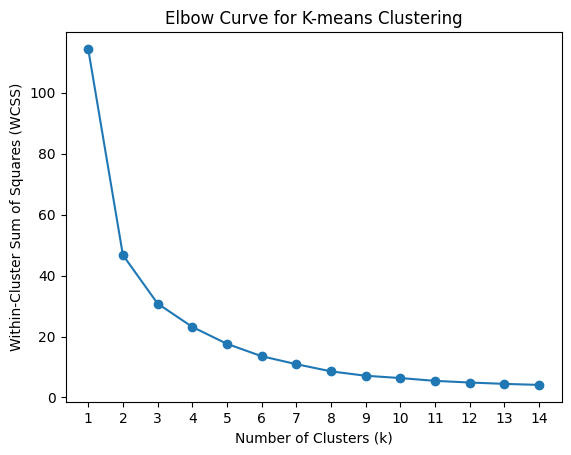

In [145]:
# Define the range of k values (from 1 to 15)
k_values = range(1, 15)

# Empty list to store the within cluster sum of squares (WCSS) for each k value
wcss_scores = []

# Here i Loop through each k value and fit KMeans model to calculate WCSS
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(geog_df)  
    wcss_scores.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, wcss_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve for K-means Clustering')
plt.xticks(range(1, 15))
plt.show()

In [146]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(geog_df)

KMeans(n_clusters=4)

In [147]:
labels = kmeans.predict(geog_df)

centroids = kmeans.cluster_centers_

In [148]:
labels

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [149]:
centroids

array([[-0.32411502, 53.7628744 ],
       [-0.842547  , 53.80271101],
       [-0.23190378, 54.06054923],
       [-0.48839187, 53.82464133]])

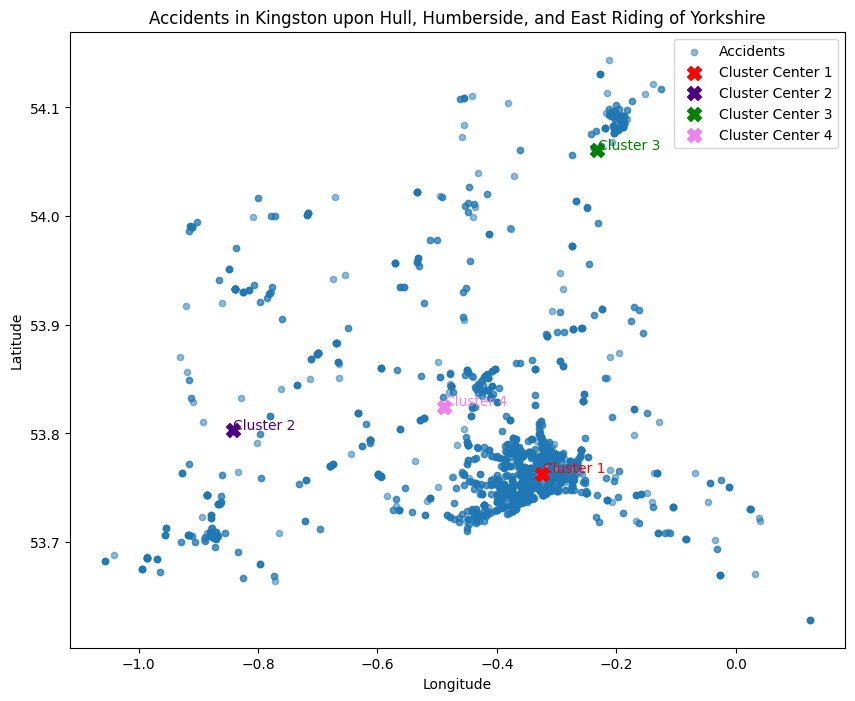

In [181]:

plt.figure(figsize=(10, 8))

# Scatter plot for accidents
plt.scatter(geog_df["longitude"], geog_df['latitude'], marker='o', s=20, alpha=0.5, label='Accidents')

# Scatter plot for cluster centers
colors = ['red','indigo','green','violet']  # List of colors for each centroid
for i, color in enumerate(colors):
    plt.scatter(centroids[i, 0], centroids[i, 1], color=color, marker='X', s=100, label=f'Cluster Center {i + 1}')
    plt.text(centroids[i, 0] + 0.001, centroids[i, 1] + 0.001, f'Cluster {i + 1}', fontsize=10, color=color)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accidents in Kingston upon Hull, Humberside, and East Riding of Yorkshire')
plt.legend()
plt.show()

In [151]:
centroids[3, 0]

-0.4883918727272727

### 6. Using outlier detection methods, identify unusual entries in your data set

In [152]:
# numerical_list = numerical_df.columns.to_list()
# numerical_list
numerical_df.columns

Index(['location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'local_authority_district',
       'first_road_class', 'first_road_number', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'second_road_class',
       'second_road_number', 'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'vehicle_index', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
      

#### Numerical Columns for Outlier Detection
 For the purpose of outlier detection, the following numerical columns have been selected from the dataset:
 1. age_of_casualty: This column represents the age of individuals involved in accidents. Outliers in this column could provide insights into the impact of extreme ages on accident circumstances and severity.

 2. age_of_vehicle: Outliers in this column might indicate vehicles that are unusually old or new, potentially shedding light on the influence of vehicle age on accidents.

 3. speed_limit: This column indicates the speed limit of the road where the accident occurred. Outliers could point to exceptional speed limits on specific road types that contribute to unique accident patterns.


In [153]:
# age_of_casualty
selected_features = ["age_of_casualty",
                     "age_of_vehicle",
                     "speed_limit",
                    "casualty_class",
                     "engine_capacity_cc"
                    ]

In [154]:
new_df = numerical_df[selected_features]

In [155]:
#Helper function to help calculate the IQR for each specified column
# inspired by class workshop
def iqr_calculator(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    return lower_bound, upper_bound

In [156]:
age_lower, age_upper = iqr_calculator(new_df['age_of_casualty'])
age_vehicle_lower, age_vehicle_upper = iqr_calculator(new_df['age_of_vehicle'])
speedLimit_lower, speedLimit_upper = iqr_calculator(new_df['speed_limit'])
engine_lower, engine_upper = iqr_calculator(new_df['engine_capacity_cc'])

In [157]:
# filter out outliers for age of driver using casualty_class to filter driver
age_outliers = numerical_df[(new_df['age_of_casualty'] < age_lower) \
                            | (new_df['age_of_casualty'] > age_upper)
                           & (new_df['casualty_class'] == 1)]

# filter out outliers for age of vehicle
outliers_age_of_vehicle = new_df[(new_df['age_of_vehicle'] < age_vehicle_lower)\
                                 | (new_df['age_of_vehicle'] > age_vehicle_upper)]

# filter out outliers for speed limit
outliers_speedLimit = new_df[(new_df['speed_limit'] < speedLimit_lower)\
                                 | (new_df['speed_limit'] > speedLimit_upper)]


# filter outliers for engine capacities
outliers_engine = new_df[(new_df['engine_capacity_cc'] < engine_lower)\
                                 | (new_df['engine_capacity_cc'] > engine_upper)]

In [158]:
# outlier for engine capacity
outliers_engine["engine_capacity_cc"].value_counts(ascending=True).nlargest()

engine_capacity_cc
125     8249
124     2735
108     1083
4500     933
6700     742
Name: count, dtype: int64

In [159]:
# speed limit outliers
outliers_speedLimit["speed_limit"].value_counts()

speed_limit
-1    14
Name: count, dtype: int64

In [160]:
# outliers for age of vehicle
outliers_age_of_vehicle["age_of_vehicle"].value_counts()

age_of_vehicle
21    752
22    462
23    310
24    212
25    144
26    101
28     92
27     81
30     62
29     60
31     57
32     42
33     20
34     19
42     17
36     16
39     16
50     12
41     11
44     11
38      9
57      8
43      8
48      8
53      8
35      7
60      6
61      6
40      5
56      5
49      4
45      4
54      4
51      4
58      3
46      3
63      3
67      3
52      3
37      3
86      2
55      2
88      2
78      1
68      1
96      1
47      1
84      1
66      1
64      1
92      1
62      1
93      1
Name: count, dtype: int64

In [161]:
# outliers for age of driver. filtered out where casualty class = 1 meaning driver/rider
age_outliers["age_of_casualty"].value_counts()

age_of_casualty
90    82
92    54
91    51
93    38
95    12
96    12
94    11
98     5
99     3
97     2
Name: count, dtype: int64

#### 
#### 
#### 
### 7. classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents

Below, i will first drop accident severity because its is the target variable and did_police_officer_attend_scene_of_accident because police are more likely to attend a fatal accident incidence


The method I am using here was inspired by the lab exercise

In [162]:
# drop accident severity and did_police_officer_attend_scene_of_accident
X = numerical_df.drop(columns=['accident_severity',
                               'did_police_officer_attend_scene_of_accident',
                                'vehicle_index',
                               'casualty_index'
                              ])
# Create a series of labels based on accident severity
y_label = numerical_df['accident_severity'] == 1  # Assigns True for fatal accidents, False otherwise
y_label.value_counts()

accident_severity
False    216204
True       4231
Name: count, dtype: int64

####  Features selection and balancing session

In [163]:
# !pip install imbalanced-learn
# !pip install --upgrade pi
# !pip install --upgrade pip
# !python -m pip install --upgrade pip


In [164]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier




In [165]:
# create an instance of RandomUnderSampler
under_sampler = RandomUnderSampler()

# resample the data using the under_sampler
X_resampled, y_resampled = under_sampler.fit_resample(X, y_label)

In [166]:
# check if y to see if we have balanced number of fatal and non fatal
y_resampled.value_counts()

accident_severity
False    4231
True     4231
Name: count, dtype: int64

##### 
Select best 20 features that can help predict if accident is fatal or not

In [167]:
# create the SelectKBest object
k_best_selector = SelectKBest(score_func=f_classif, k=15)

# fit the selector on X_resampled data
X_resampled_selected = k_best_selector.fit_transform(X_resampled, y_resampled)

# get the indices of the selected features
selected_feature_indices = k_best_selector.get_support(indices=True)

# get the names of the selected features
selected_feature_names = X_resampled.columns[selected_feature_indices]

# print the selected feature names
print("Selected features:", selected_feature_names)

Selected features: Index(['police_force', 'number_of_vehicles', 'number_of_casualties',
       'local_authority_district', 'first_road_class', 'speed_limit',
       'second_road_class', 'urban_or_rural_area',
       'vehicle_location_restricted_lane', 'junction_location',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'vehicle_left_hand_drive', 'age_of_casualty',
       'casualty_home_area_type'],
      dtype='object')


In [168]:
# get the mask for the selected features
feature_mask = k_best_selector.get_support()

# Get the names and scores of the selected features
selected_feature_names = X_resampled.columns[feature_mask]
selected_feature_scores = k_best_selector.scores_[feature_mask]

# Create a dictionary to store feature names and scores
selected_features_dict = {
    'Feature': selected_feature_names,
    'Score': selected_feature_scores
}

# Convert the dictionary to a DataFrame for better visualization
selected_features_df = pd.DataFrame(selected_features_dict)
# Print the DataFrame with selected feature names and scores
selected_features_df

,Feature,Score
0,police_force,337.989546
1,number_of_vehicles,224.738298
2,number_of_casualties,651.608165
3,local_authority_district,358.285324
4,first_road_class,293.361729
5,speed_limit,1305.325834
6,second_road_class,497.359679
7,urban_or_rural_area,1037.545707
8,vehicle_location_restricted_lane,262.801880
9,junction_location,414.742251


#### Bar Chart of the features and thescores

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'police_force'),
  Text(1, 0, 'number_of_vehicles'),
  Text(2, 0, 'number_of_casualties'),
  Text(3, 0, 'local_authority_district'),
  Text(4, 0, 'first_road_class'),
  Text(5, 0, 'speed_limit'),
  Text(6, 0, 'second_road_class'),
  Text(7, 0, 'urban_or_rural_area'),
  Text(8, 0, 'vehicle_location_restricted_lane'),
  Text(9, 0, 'junction_location'),
  Text(10, 0, 'hit_object_in_carriageway'),
  Text(11, 0, 'hit_object_off_carriageway'),
  Text(12, 0, 'vehicle_left_hand_drive'),
  Text(13, 0, 'age_of_casualty'),
  Text(14, 0, 'casualty_home_area_type')])

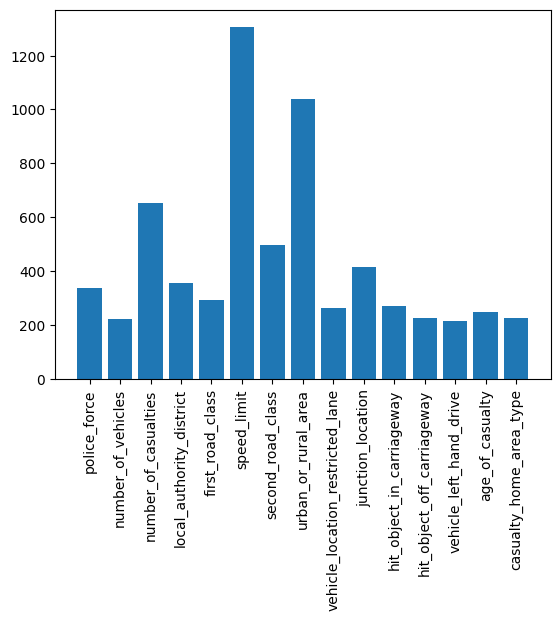

In [169]:
plt.bar(selected_feature_names,selected_feature_scores)
plt.xticks(rotation= "vertical")

#### 
define some functions that will be used later.
thee functions where inspired by the lap workshops

In [170]:
# Inspired by the given lab work and guidiance 
def get_models():
    models = dict()
    models['dtree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['rnd'] = RandomForestClassifier()
    return models

In [171]:
# Inspired by the given lab work and guidiance 
def evaluate_model(model, X, y):
    """
        Evaluate a model
    """
    # cross verify
    cv = RepeatedStratifiedKFold(
        n_splits=10,
        n_repeats = 3,
        random_state = 1
        )

    # get scores 
    scores = cross_val_score(
        model,X,y,
        scoring = "accuracy",
        cv =cv, error_score='raise'
    )
    return scores

#### Split data into training and testing sets

In [172]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
        y_resampled, test_size=0.2, random_state=42)



In [173]:
# get model 
models = get_models()

##### Get Score for the defined models. This will help in selecting the best model for the classification task

In [174]:
# initialize an empty list to store names and result of evaluation
# of models to help select which model will best work fo the 
# classificaton task
names = []
results = []
stds = []

# loop through the defined models
for name, model in models.items():
#     call defined function to get the model score
    scores = evaluate_model(model, X_train, y_train)
#     store the result
    results.append(scores)
    names.append(name)
    stds.append(f"{np.std(scores):4.3f}")
    print(f"{name}: {np.mean(scores):3.2f} {np.std(scores):4.3f}")

dtree: 0.80 0.017
knn: 0.74 0.014
rnd: 0.87 0.014


### From the above output, we can see that the best mode with higher accuracy is random forest defined as rndf
Due to this reason, I will be using random forest algorithm to train my model

In [175]:
# the (Random Forest) classification model
classifier = RandomForestClassifier(random_state=42)

In [176]:
# fit the model on the training data
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [177]:
# predicting the accident severity on the test data
y_pred = classifier.predict(X_test)

In [178]:
# calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8812758417011223


In [179]:
# print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.87      0.88       838
        True       0.87      0.89      0.88       855

    accuracy                           0.88      1693
   macro avg       0.88      0.88      0.88      1693
weighted avg       0.88      0.88      0.88      1693

Confusion Matrix:
[[728 110]
 [ 91 764]]


In [180]:
# Create a DataFrame to display actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.head(40)

,Actual,Predicted
6679,True,True
7908,True,True
625,False,False
4959,True,True
828,False,False
1557,False,False
6644,True,True
1926,False,False
5306,True,True
7238,True,True
